# 1D scalar wave equation PML profiles
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](www.ausargeo.com))*

When numerically simulating wave propagation, such as for seismic imaging/inversion, we often run the simulation on a limited area. To avoid reflections from the boundaries of this limited area, we need to absorb waves reaching the boundaries. For 2D and 3D finite difference wave propagation, I think the most popular way by far to do this these days is with a technique known as a perfectly matched layer (PML). Steven G. Johnson has a [very clear introduction](http://math.mit.edu/~stevenj/18.369/pml.pdf) to the topic. One parameter of the method is the  size of the PML. Like many things, bigger is better here, as a thicker PML enables better absorption. Once the thickness is decided, the only other parameter is the shape of the sigma function (See SGJ's introduction for an explanation of what sigma is), which I refer to as the "profile". I don't think it is obvious what the best shape for this profile is in theory (if you know of such work, please let me know!), so in this notebook I experiment with a few different profiles to see what works best. To keep the computational cost down, I only work in 1D. It's possible that the profiles behave differently in other dimensions, but that is a job for another notebook.

To facilitate this exploration, I wrote a little bit of code, which I import below. It primarily consists of a Fortran code to do the wave propagation and apply the PML, and Python code to create synthetic models and run an optimizer to find good profiles.

The [Fortran code](https://github.com/ar4/wave_1d_fd_pml/blob/master/wave_1d_fd_pml/pml.f90) contains my derivation of the PML code for the 1D scalar wave equation (in the comment at the beginning of the `fd_pml1` subroutine). This differs slightly from [the PML implementation](https://github.com/pysit/pysit/blob/master/pysit/solvers/constant_density_acoustic/time/scalar/constant_density_acoustic_time_scalar_1D_4.h) I found in [PySIT](www.pysit.org). I'm not sure where the PySIT version comes from, but it has some advantages over my own. The largest of these is that outside of the PML region you can just use the regular scalar wave equation, whereas with my implementation you need to use a modified propagator everywhere. I thus compare both implementations below. My own is referred to as version 1, and the PySIT one is version 2.

In [1]:
from wave_1d_fd_pml import propagators, test_wave_1d_fd_pml, find_profile
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(0)

I am going to use a profile length of 10 cells. This means that on both ends of my 1D domain, I add 10 cells where sigma will be non-zero, causing any incoming waves to be attenuated (hopefully so much that they disappear). The values of sigma in these 10 cells, the "profile", are what I am trying to optimize below.

Just to make completely sure that we are all on the same page, here's a plot of sigma over the whole domain:

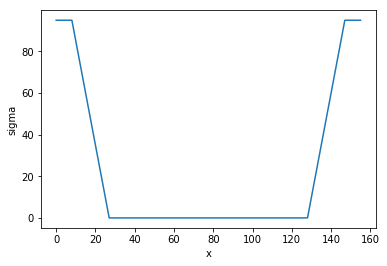

In [2]:
v = propagators.Pml1(np.ones(100), 5)
plt.plot(v.sigma)
plt.xlabel('x')
plt.ylabel('sigma')

Sigma is zero in the interior of the domain - the place where we want to propagate the waves normally. The shape it has at the edges of the domain, where it causes waves to be attenuated, is what we are going to explore. Our sigma will be the same on both sides of the domain, so we will just talk about the shape on the right side from now on, but it will always be mirrored on the left side.

10 is a fairly arbitrary choice (it's one quarter of the wavelength of a 25 Hz wave in a 5000 m/s medium, when the cell size is 5 m). For longer wavelengths or smaller cell sizes, you may need to increase it.

I also choose the `maxiter` value to be 1024 in the next cell. This controls the number of iterations that the optimizers run for below.

The `vs` variables contains the array of velocities that will be used when evaluating the PML effectiveness. More velocities makes the process slower but may improve the robustness of the results.

In [3]:
profile_len = 10
maxiter = 1024
vs = np.linspace(1500, 5000, 3)

## Profile optimization

To explore the kinds of profiles that work well, I am going to try different ones and test how effective they are. My measure of effectiveness will be the sum of absolute values of the wavefield after 500 timesteps in a simple model that consists of one 25 Hz Ricker wavelet source, and one reflector. To improve the generality of the results, I run the wave propagation multiple times with different wave speeds on either side of the reflector, so the results are not tuned for specific wave speeds.

I use a combination of two different optimizers to find good parameters for the profiles. I first do a quick brute force search over the range of parameter values that I think are plausible. I then pass the best parameters this finds as an initial guess for the second optimizer. The second optimizer is [HyGSA](https://github.com/sgubianpm/pygensa). This is a type of simulated annealing algorithm, and apparently works well in many cases. I do not know that the cost function (the sum of the absolute wavefield values, as mentioned above) is convex, and my brute force search is too coarse to be confident that the initial guess is close to the global minimum, so I need to use a global optimizer like this. Some of the profile models I explore have quite a few parameters, so a more thorough brute force parameter search would be too expensive.

### Linear profile

A linear profile is often used for PMLs. It corresponds to `sigma[i] = x[0] + x[1] * i`, where `i` is the distance into the PML.

In [84]:
profile = lambda x: x[0] + x[1] * np.arange(profile_len)
bounds = ((0, 5000), (0, 500))
x_linear1, _, _ = find_profile.find_profile(profile, bounds, optimizer='brute', pml_version=1, vs=vs, maxiter=maxiter)
x_linear1, profile_linear1, cost_linear1 = find_profile.find_profile(profile, bounds, optimizer='hygsa', init=x_linear1, pml_version=1, vs=vs, maxiter=maxiter)

x_linear2, _, _ = find_profile.find_profile(profile, bounds, optimizer='brute', pml_version=2, vs=vs, maxiter=maxiter)
x_linear2, profile_linear2, cost_linear2 = find_profile.find_profile(profile, bounds, optimizer='hygsa', init=x_linear2, pml_version=2, vs=vs, maxiter=maxiter)

brute pml  1  global minimum: xmin = [ -8.73588562e-04   3.85190201e+01], f(xmin) = 5.959280014038086
hygsa pml  1  global minimum: xmin = [ 29.74938308  63.14288128], f(xmin) = 0.2556930184364319
brute pml  2  global minimum: xmin = [ -6.18715286e-05   8.59533389e+01], f(xmin) = 0.46265149116516113
hygsa pml  2  global minimum: xmin = [ 41.07094101  58.03234615], f(xmin) = 0.2618347704410553


The results for the two PML implementations (the first is my own, the second is the one from PySIT) are shown above. It first gives us the values of `x[0]` and `x[1]` that resulted in the most effective PML (smallest cost function, which is the sum of absolute values of the wavefield at the final time step, indicating that the waves had been strongly attenuated when they reached the edges of the domain). The value of the cost function for these parameter values is also given as `f(xmin)`.

We see that in both my implementation and the one I got from PySIT, the PML works best when the intercept of the linear profile is nonzero (around 35). Interestingly, this is quite a bit smaller than the optimal slope values found, which are around 60 for the two implementations. This means that for the first cell in the PML region we take a little jump in sigma, but then a bigger jump for the rest of the cells. Does this perhaps suggest that a profile that allows curvature might do better? Maybe we need to increase the rate at which sigma is increasing as we go deeper into the PML. We'll try that next.

The other thing to note is that both PML implementations (mine and PySIT) performed about equally - the cost function of the best parameters was similar for both (around 0.26), indicating that they both attenuated the waves equally effectively.


### Powers of linear functions

Since the previous result suggested that some curvature might be beneficial, I will next try giving the optimizer an additional parameter to explore by raising the value of the depth into the PML to a variable power. This corresponds to `sigma[i] = x[0] + x[1] * i ^ x[2]`.

After doing the brute force search this time, I compare the cost function of the best profile it finds with the cost of the best linear profile. If it is higher (worse) than the linear one, then I set the initial guess for HyGSA to be the linear parameters, with 1 for the power parameter.

In [93]:
profile = lambda x: x[0] + x[1] * np.arange(profile_len) ** x[2]
bounds = ((0, 5000), (0, 500), (0.1, 10))
x_power1, _, cost_power1 = find_profile.find_profile(profile, bounds, optimizer='brute', pml_version=1, vs=vs, maxiter=maxiter)
if cost_linear1 < cost_power1:
    init = np.append(x_linear1, 1)
else:
    init = x_power1
x_power1, profile_power1, cost_power1 = find_profile.find_profile(profile, bounds, optimizer='hygsa', init=init, pml_version=1, vs=vs, maxiter=maxiter)

x_power2, profile_power2, cost_power2 = find_profile.find_profile(profile, bounds, optimizer='brute', pml_version=2, vs=vs, maxiter=maxiter)
if cost_linear2 < cost_power2:
    init = np.append(x_linear2, 1)
else:
    init = x_power2
x_power2, profile_power2, cost_power2 = find_profile.find_profile(profile, bounds, optimizer='hygsa', init=init, pml_version=2, vs=vs, maxiter=maxiter)

brute pml  1  global minimum: xmin = [  9.00139677e-04   1.11782462e+01   1.90596267e+00], f(xmin) = 0.16674724221229553
hygsa pml  1  global minimum: xmin = [  9.00139677e-04   1.28252046e+01   1.83259019e+00], f(xmin) = 0.16611707210540771
brute pml  2  global minimum: xmin = [  9.85243056e-05   6.24246480e+01   1.37603311e+00], f(xmin) = 0.3479134440422058
hygsa pml  2  global minimum: xmin = [ 41.07094101  58.03234615   1.        ], f(xmin) = 0.2745470404624939


The optimizer did find this additional flexibility useful for my PML implementation: the value it found for `x[2]`, the power, is different from 1 (1.83), but not for the PySIT PML implementation (where the best `x[2]` is 1).

Let's have another go with a different type of curvature.


### Cosine

This time I'm going to try `sigma[:] = x[0] + x[1] * cos(linspace(x[2], x[2] + x[3], profile_len))`. That's quite a bit of flexibility. The optimizer gets to choose a constant bias (`x[0]`), a scaling factor of the cosine (`x[1]`), and the range of the 10 values that the cosine is applied to (linearly spaced between `x[2]` and `x[2] + x[3]`). Let's see what it comes up with.

In [94]:
profile = lambda x: x[0] + x[1] * np.cos(np.linspace(x[2], x[2] + x[3], profile_len))
bounds = ((0, 5000), (-500, 0), (0, np.pi/2), (0, np.pi/2))
x_cosine1, _, _ = find_profile.find_profile(profile, bounds, optimizer='brute', pml_version=1, vs=vs, maxiter=maxiter)
x_cosine1, profile_cosine1, cost_cosine1 = find_profile.find_profile(profile, bounds, optimizer='hygsa', init=x_cosine1, pml_version=1, vs=vs, maxiter=maxiter)

x_cosine2, _, _ = find_profile.find_profile(profile, bounds, optimizer='brute', pml_version=2, vs=vs, maxiter=maxiter)
x_cosine2, profile_cosine2, cost_cosine2 = find_profile.find_profile(profile, bounds, optimizer='hygsa', init=x_cosine2, pml_version=2, vs=vs, maxiter=maxiter)

brute pml  1  global minimum: xmin = [ -1.81628814e-04  -6.62734466e+02   1.60621667e+00   6.19939583e-01], f(xmin) = 0.4115280508995056
hygsa pml  1  global minimum: xmin = [  31.71926487 -421.97593432    1.57079627    1.43059129], f(xmin) = 0.2685890197753906
brute pml  2  global minimum: xmin = [  5.48429154e-04  -4.67359643e+02   1.67087628e+00   1.41243625e+00], f(xmin) = 0.26949959993362427
hygsa pml  2  global minimum: xmin = [ 407.26725908 -433.40660744    0.55389735    1.53657457], f(xmin) = 0.2531021237373352


With the amount of iterations I allowed, the optimizer did not find better profiles than it did with the previous models: the cost function values of the best parameters are similar for both PML implementations to previous profiles. The profiles do have some curvature this time (`x[3]` is not zero). It is possible, though, that the results might have been better with more optimizer iterations. This profile has more parameters than previous profiles, and so is harder to optimize.


### Free-form

Finally, I'll give the optimizer free rein to choose whatever profile it wants. This time, the value of sigma at each cell in the profile is a parameter, so `sigma[i] = x[i]`. Such an unconstrained model will be very challenging for the optimizer, but let's see what happens anyway.

The initial guess for HyGSA is the best of the previous profiles, or the result of a quick brute force search, whichever has the lowest cost function value.

In [96]:
profile = lambda x: x
bounds = [(0, 5000)] * profile_len
x_freeform1, _, cost_freeform1 = find_profile.find_profile(profile, bounds, optimizer='brute', pml_version=1, vs=vs, maxiter=maxiter)
if cost_linear1 < cost_freeform1:
    init = profile_linear1
else:
    init = x_freeform1
if cost_power1 < cost_linear1:
    init = profile_power1
if cost_cosine1 < cost_power1:
    init = profile_cosine1
x_freeform1, profile_freeform1, cost_freeform1 = find_profile.find_profile(profile, bounds, optimizer='hygsa', init=init, pml_version=1, vs=vs, maxiter=maxiter)

x_freeform2, _, cost_freeform2 = find_profile.find_profile(profile, bounds, optimizer='brute', pml_version=2, vs=vs, maxiter=maxiter)
if cost_linear2 < cost_freeform2:
    init = profile_linear2
else:
    init = x_freeform2
if cost_power2 < cost_linear2:
    init = profile_power2
if cost_cosine2 < cost_power2:
    init = profile_cosine2
x_freeform2, profile_freeform2, cost_freeform2 = find_profile.find_profile(profile, bounds, optimizer='hygsa', init=init, pml_version=2, vs=vs, maxiter=maxiter)

brute pml  1  global minimum: xmin = [  2.06276610e-04  -2.67818689e-05   8.75338789e-06   1.87582154e-05
   1.15400538e-05  -1.42327605e-05   1.19151425e-05   1.07992159e-05
   1.88320019e-05  -1.46301551e-05], f(xmin) = 3518.19970703125
hygsa pml  1  global minimum: xmin = [  6.22417851e-01   1.28184536e+01   4.52120551e+01   9.61180166e+01
   1.53646951e+02   2.19760324e+02   3.30891096e+02   4.74530398e+02
   5.66987839e+02   6.44188872e+02], f(xmin) = 0.14932510256767273
brute pml  2  global minimum: xmin = [ -2.05595010e-07  -2.69846183e-07   9.27897712e-07   5.84436298e-07
  -5.24787728e-07   1.86361062e-07  -3.76305466e-07   1.02719280e-06
   4.26697337e-07   2.49076861e-04], f(xmin) = 3517.66748046875
hygsa pml  2  global minimum: xmin = [  124.34587107   337.88748999   579.33868168  2097.99424901  1161.28010208
     9.35917754  1993.47274645    77.10956837  2203.25361796   566.68014302], f(xmin) = 0.1094118058681488


Interestingly, the additional freedom does seem to have allowed the optimizers to find profiles that reduce the mean cost over the considered velocities quite a bit compared to the more restrictive profile models we looked at above. The best profile that was found for the PySIT PML looks rather spiky, though, which is concerning.


## Results

The best profiles that we found are plotted below for the two PML versions (my implementation is the first plot, the PySIT one is the second plot).

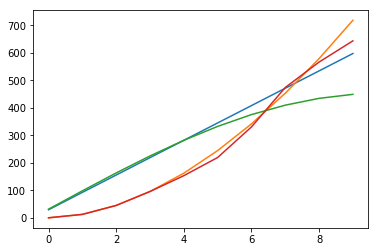

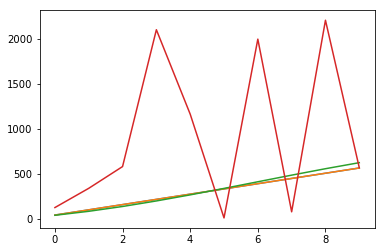

In [105]:
profiles=[[profile_linear1, profile_power1, profile_cosine1, profile_freeform1],
         [profile_linear2, profile_power2, profile_cosine2, profile_freeform2]]
for pml_version, profiles in enumerate(profiles):
    plt.figure()
    for profile in profiles:
        plt.plot(profile)

As I said, the free-form profile for the second implementation is quite strange looking.

During optimization, I only considered three possible velocities on each side of the reflector in the model, giving nine models with different velocity combinations. The cost associated with each profile was the sum of the absolute amplitude values of the propagated wavefields across all of these models. The idea of using multiple models was, as stated above, to reduce the risk of profiles being chosen that only work well with a particular velocity. Using more velocities would have been even better for ensuring generalizability, but would also have greatly increased the computational cost of the optimizations. The cost function values reported for each profile are thus only guidelines. To get a more accurate comparison of how the different PML profiles we found perform, I will now test them with a larger range of velocities (10 on each side of the reflector, so 100 combinations).

In [114]:
nv = 10
e = np.zeros([nv**2, 8])
vs2 = np.linspace(1500, 5000, nv)
for v0i, v0 in enumerate(vs2):
    for v1i, v1 in enumerate(vs2):
        model = test_wave_1d_fd_pml.model_one(500, v0=v0, v1=v1, freq=25)
        profiles=[[profile_linear1, profile_power1, profile_cosine1, profile_freeform1],
                 [profile_linear2, profile_power2, profile_cosine2, profile_freeform2]]
        for pml_version, profiles in enumerate(profiles):
            if pml_version == 0:
                prop = propagators.Pml1
            else:
                prop = propagators.Pml2
            for pi, profile in enumerate(profiles):
                v = prop(model['model'], model['dx'], model['dt'], len(profile), profile=profile)
                y = v.steps(model['nsteps'], model['sources'], model['sx'])
                e[v0i*nv+v1i, pml_version*4+pi] = (np.sum(np.abs(v.current_wavefield)))

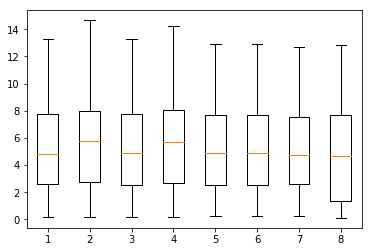

In [115]:
plt.boxplot(e);

The plot above shows [box plots](https://en.wikipedia.org/wiki/Box_plot) for the eight PML profiles The first four boxes (from the left) are the linear, power, cosine, and free-form profiles with my PML implementation. The next four are for the PySIT PML implementation.

The most striking feature is how similar the results are for the different profiles. Even the shockingly spiky free-form profile for PML 2 (the right-most box) behaves almost the same as the rest. After all of our optimization work, it's a little bit disappointing - the shape of sigma doesn't actually seem to affect the effectiveness of the PML that much.

Another feature I notice is that my PML implementation (the four boxes on the left) seems to be a bit less stable than the PySIT implementation. The median (the coloured line in the middle) for the PySIT results is almost constant, but there is some variation with mine.

A final observation is that, although the median residual wave amplitude when using the free-form profile for the PySIT PML is similar to the others, the 25th percentile (the bottom of the box) is noticeably lower). So, despite it's strange appearance, there are times when the spiky profile does better than the more plausible looking smooth profiles. Despite this, I would still be more comfortable with one of the simpler ones.

Let's see one of these profiles in action.

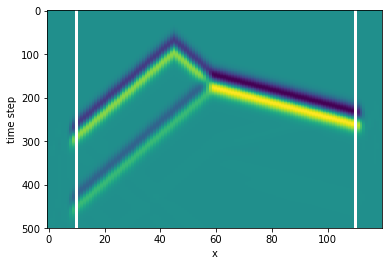

In [119]:
profile = profile_freeform2
prop = propagators.Pml2
model = test_wave_1d_fd_pml.model_one(500, v0=1500, v1=5000, freq=25)
v = prop(model['model'], model['dx'], model['dt'], len(profile), profile=profile)
y = v.steps(model['nsteps'], model['sources'], model['sx'])
y[:, v.total_pad] = y[:, -v.total_pad] = np.nan
plt.imshow(y[:,8:-8], aspect='auto')
plt.xlabel('x')
plt.ylabel('time step')

This shows the 1D wave propagating as time advances. The source, at about `x=40`, starts emitting significant energy around time step 50. Since this is 1D propagation, the wave travels to the left and the right from the source. The half that travelled to the right soon (around time step 175) encounters the reflector. It thus splits into transmitted (continuing to the right) and reflected (going back to the left) components.

In [31]:
import importlib

In [53]:
importlib.reload(test_wave_1d_fd_pml)

<module 'wave_1d_fd_pml.test_wave_1d_fd_pml' from '/quake/home/alan_r/wave_1d_fd_pml/wave_1d_fd_pml/test_wave_1d_fd_pml.py'>

In [91]:
importlib.reload(find_profile)

<module 'wave_1d_fd_pml.find_profile' from '/quake/home/alan_r/wave_1d_fd_pml/wave_1d_fd_pml/find_profile.py'>

In [103]:
dxs = np.arange(1,5)
x_dx = np.zeros([5, 2])
x_dx[-1, :] = x_linear2
profile = lambda x: x[0] + x[1] * np.arange(profile_len)
bounds = ((0, 5000), (0, 500))
for i, dx in enumerate(dxs):
    profile_len_dx = int(profile_len * 5 / dx)
    x_dx[i, :], _, _ = find_profile.find_profile(profile, bounds, optimizer='brute', pml_version=2, vs=vs, maxiter=maxiter)
    x_dx[i, :], _, _ = find_profile.find_profile(profile, bounds, optimizer='hygsa', init=x_dx[i, :], pml_version=2, vs=vs, maxiter=maxiter)    

brute pml  2  global minimum: xmin = [ -6.18715286e-05   8.59533389e+01], f(xmin) = 0.46265149116516113
hygsa pml  2  global minimum: xmin = [ 41.2066493   58.70666794], f(xmin) = 0.26255691051483154
brute pml  2  global minimum: xmin = [ -6.18715286e-05   8.59533389e+01], f(xmin) = 0.46265149116516113
hygsa pml  2  global minimum: xmin = [ 38.55652306  58.61380101], f(xmin) = 0.26258406043052673
brute pml  2  global minimum: xmin = [ -6.18715286e-05   8.59533389e+01], f(xmin) = 0.46265149116516113
hygsa pml  2  global minimum: xmin = [ 42.98287064  58.1329107 ], f(xmin) = 0.2619428038597107
brute pml  2  global minimum: xmin = [ -6.18715286e-05   8.59533389e+01], f(xmin) = 0.46265149116516113
hygsa pml  2  global minimum: xmin = [ 38.88091802  58.57914507], f(xmin) = 0.2625476121902466


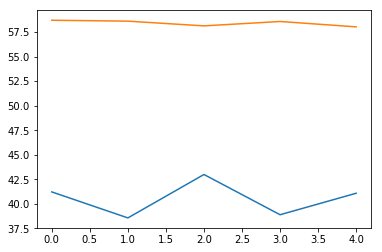

In [104]:
plt.plot(x_dx)

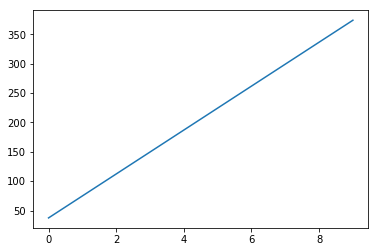

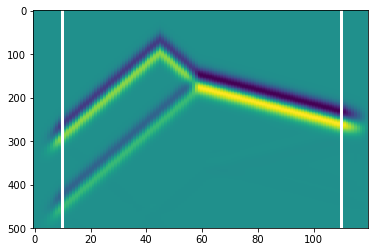

In [51]:
dx=5
dt = 0.0006 * dx / 5
N = int(100 * 5 / dx)
nsteps = int(500 * 0.0006 / dt)
profile_len_dx = int(profile_len * 5 / dx)
profile = x_dx[0,0] + x_dx[0,1] * np.arange(profile_len_dx)
plt.plot(profile)
plt.figure()
prop = propagators.Pml2
model = test_wave_1d_fd_pml.model_one(nsteps, v0=1500, v1=5000, freq=25, dx=dx, dt=dt, N=N)
v = prop(model['model'], model['dx'], model['dt'], len(profile), profile=profile)
y = v.steps(model['nsteps'], model['sources'], model['sx'])
y[:, v.total_pad] = y[:, -v.total_pad] = np.nan
plt.imshow(y[:,8:-8], aspect='auto')

In [59]:
x_power12, profile_power12 = find_profile.find_profile_power(profile_len, maxiter=maxiter, vs=vs, pml_version=1)
x_power22, profile_power22 = find_profile.find_profile_power(profile_len, maxiter=maxiter, vs=vs, pml_version=2)

global minimum: xmin = [  8.48934299e-04   1.48420120e+02   1.00240903e+00   7.10465156e+01], f(xmin) = 0.4057510495185852
global minimum: xmin = [  82.13302831  262.04533704    1.01470999   17.95033932], f(xmin) = 0.3005094826221466


In [68]:
profile = lambda x: x[0] + x[1] * np.arange(profile_len)
x_linear12, profile_linear12 = find_profile.find_profile(profile, [80, 260], ((0, 5000), (0, 500)), optimizer='brute', vs=vs, pml_version=1, brute_Ns=50)

global minimum: xmin = [ -1.71386719e-04   3.78627232e+01], f(xmin) = 5.985506057739258


In [70]:
x_linear13, profile_linear13 = find_profile.find_profile(profile, [x_linear12[0], x_linear12[1]], ((0, 5000), (0, 500)), optimizer='hygsa', vs=vs, pml_version=1, hygsa_maxiter=500)

global minimum: xmin = [ 28.59340887  60.68163227], f(xmin) = 0.2489261031150818


In [73]:
int(maxiter** (1/10))

1

In [74]:
2**10

1024